# Entity Resolution project @ Wavestone
## Entity Matching

> *Datasets information from [here](https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/index.html)*

> **Tristan PERROT**


## Import libraries


In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
import os

import torch

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:1


In [5]:
while 'model' not in os.listdir():
    os.chdir('..')

In [6]:
MODEL_NAME = ''
DATA_NAME = 'wdc_xlarge_cameras'
COMPUTER = 'gpu5.enst.fr:' + str(device)[-1:]
DATA_DIR = os.path.join('data', DATA_NAME)

## Pre-processing

In [7]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
from sentence_transformers import CrossEncoder, InputExample, SentencesDataset
from sentence_transformers.cross_encoder.evaluation import \
    CEBinaryClassificationEvaluator
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader

from model.utils import load_data

In [8]:
!python import_data.py --dataset $DATA_NAME


Downloaded dataset: wdc_xlarge_cameras 



In [9]:
table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(DATA_DIR,)

Table A columns:
        column_name                                       data_example
1       description  "\n                            Cámara CANON Pr...
2  specTableContent   Marca CANON Megapixeles 20.2 MP TAMAÑO DE PAN...
3             title   " Cámara CANON EOS 6D + Lente EF 24-105L "@es... 

Table B columns:
        column_name                                       data_example
1       description  "\n                            Cámara CANON Pr...
2  specTableContent   Marca CANON Megapixeles 20.2 MP TAMAÑO DE PAN...
3             title   " Cámara CANON EOS 6D + Lente EF 24-105L "@es... 

Serialized entities 



In [10]:
X1_train, X2_train = [table_a_serialized[i[0]] for i in X_train_ids], [table_b_serialized[i[1]] for i in X_train_ids]
X1_valid, X2_valid = [table_a_serialized[i[0]] for i in X_valid_ids], [table_b_serialized[i[1]] for i in X_valid_ids]
X1_test, X2_test = [table_a_serialized[i[0]] for i in X_test_ids], [table_b_serialized[i[1]] for i in X_test_ids]

In [11]:
# Display the first 5 samples of the training set
for i in range(5):
    print(f'Sample {i}:')
    print(f'Entity1: {X1_train[i]}')
    print(f'Entity2: {X2_train[i]}')
    print(f'Label: {y_train[i]}')
    print()

Sample 0:
Entity1: [COL] brand [VAL] "Canon"@en [COL] description [VAL] "
30.4MP Full-Frame CMOS Sensor
EF 24-105mm f/4L IS II USM Lens
DIGIC 6+ Image Processor
3.2" 1.62m-Dot Touchscreen LCD Monitor
DCI 4K Video at 30 fps; 8.8MP Still Grab
61-Point High Density Reticular AF
Native ISO 32000, Expanded to ISO 102400
Dual Pixel RAW; AF Area Select Button
Dual Pixel CMOS AF and Movie Servo AF
7 fps Shooting; CF & SD Card Slots
Built-In GPS and Wi-Fi with NFC
"@en  [COL] specTableContent [VAL]  [COL] title [VAL]  "Canon EOS 5D Mark IV DSLR Camera with 24-105mm f/4L II Lens"@en Lens 1483C010 - Studio Depot"@en
Entity2: [COL] brand [VAL]  [COL] description [VAL] "
                            Cámara CANON Profesional EOS 6D + Lente EF 24-105 L IS USM 
Mega Pixeles: 20.2 MPPantalla LCD: 3.0"Video: (1080: 30p 29.97/24p 23.976/25p, 720: 60p 59.94/50p, 480: 30p (29.97)/25p)Accesorios: BATERIA-CARGADOR
 Este producto tiene promesa de entrega de 45 días, a partir del momento de la compra
CONSÍGUELO

In [12]:
train_datasets = [InputExample(texts=[X1_train[i], X2_train[i]], label=y_train[i]) for i in range(len(X_train_ids))]
valid_datasets = [InputExample(texts=[X1_valid[i], X2_valid[i]], label=y_valid[i]) for i in range(len(X_valid_ids))]
test_datasets = [InputExample(texts=[X1_test[i], X2_test[i]], label=y_test[i]) for i in range(len(X_test_ids))]
train_loader = DataLoader(train_datasets, shuffle=True, batch_size=16, num_workers=0)
valid_loader = DataLoader(valid_datasets, shuffle=False, batch_size=16, num_workers=0)
test_examples = DataLoader(test_datasets, shuffle=False, batch_size=16, num_workers=0)

valid_evaluation_set = [(e1, e2) for e1, e2 in zip(X1_valid, X2_valid)]

In [13]:
EPOCHS = 3
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 300
CLASSIFIER_DROPOUT = None
threshold = 0.5

loss_fct = BCEWithLogitsLoss()

def callback(score, epoch, steps):
    print(f'Epoch {epoch} - Score {score} - Steps {steps}')

In [14]:
final_table_exports = ""
results = {}

In [32]:
def show_results():
    global results
    roc_curve_fig, roc_curve_ax = plt.subplots(figsize=(10, 10))
    acc_threshold_fig, acc_threshold_ax = plt.subplots(figsize=(10, 10))
    prec_recall_threshold_fig, prec_recall_threshold_ax = plt.subplots(figsize=(10, 10))
    f1_threshold_fig, f1_threshold_ax = plt.subplots(figsize=(10, 10))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, (model_name, (logits, train_time)) in enumerate(results.items()):
        y_pred = logits > threshold
        y_true = y_test
        print(f'Model: {model_name}')
        print(classification_report(y_true, y_pred))
        print(f'AUC: {roc_auc_score(y_true, logits)}')
        print(f'Train time: {train_time}')
        print()
        fpr, tpr, _ = roc_curve(y_true, logits)
        roc_curve_ax.plot(fpr, tpr, label=model_name)

        # Confusion matrix
        plt.figure()
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')

        thresholds = np.linspace(0, 1, 100)
        accuracies = []
        precions = []
        recalls = []
        f1_scores = []
        for th in thresholds:
            y_pred = logits > th
            accuracies.append(np.mean(y_pred == y_true))
            precions.append(np.sum(y_pred * y_true) / np.sum(y_pred) if np.sum(y_pred) != 0 else 1)
            recalls.append(np.sum(y_pred * y_true) / np.sum(y_true))
            f1_scores.append(2 * precions[-1] * recalls[-1] / (precions[-1] + recalls[-1]) if precions[-1] + recalls[-1] != 0 else 0)
        acc_threshold_ax.plot(thresholds, accuracies, label=model_name)
        prec_recall_threshold_ax.plot(thresholds, precions, label=model_name + " precision", color=colors[i])
        prec_recall_threshold_ax.plot(thresholds, recalls, label=model_name + " recall", color=colors[i], linestyle='--')
        f1_threshold_ax.plot(thresholds, f1_scores, label=model_name)


    
    roc_curve_ax.plot([0, 1], [0, 1], 'k--')
    roc_curve_ax.set_xlabel('False Positive Rate')
    roc_curve_ax.set_ylabel('True Positive Rate')
    roc_curve_ax.set_title('ROC curve')
    roc_curve_ax.legend()

    acc_threshold_ax.set_xlabel('Threshold')
    acc_threshold_ax.set_ylabel('Accuracy')
    acc_threshold_ax.set_title('Accuracy vs Threshold')
    acc_threshold_ax.legend()

    prec_recall_threshold_ax.set_xlabel('Threshold')
    prec_recall_threshold_ax.set_ylabel('Precision/Recall')
    prec_recall_threshold_ax.set_title('Precision/Recall vs Threshold')
    prec_recall_threshold_ax.axvline(x=threshold, color='k', linestyle='--', label=f'Threshold = {threshold}')
    prec_recall_threshold_ax.legend()

    f1_threshold_ax.set_xlabel('Threshold')
    f1_threshold_ax.set_ylabel('F1 Score')
    f1_threshold_ax.set_title('F1 Score vs Threshold')
    f1_threshold_ax.axvline(x=threshold, color='k', linestyle='--', label=f'Threshold = {threshold}')
    f1_threshold_ax.legend()

    plt.show()

### MS Marco MiniLM l-12

- Architecture: MiniLM-L-12
- Parameters: ~33 million
- Layers: 12 Transformer layers
- Hidden Size: 384
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/ms-marco-TinyBERT-L-2-v2)
- MS MARCO Passage Retrieval is a large dataset with real user queries from Bing search engine with annotated relevant text passages.

In [16]:
MODEL_NAME = 'cross-encoder/ms-marco-MiniLM-L-12-v2'
OUTPUT_PATH = os.path.join('results', DATA_NAME, MODEL_NAME)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [17]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT, default_activation_function=nn.Sigmoid())

In [18]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            output_path=OUTPUT_PATH,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2114 [00:00<?, ?it/s]

Batches:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 0 - Score 0.9138784054738207 - Steps -1


Iteration:   0%|          | 0/2114 [00:00<?, ?it/s]

Batches:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 1 - Score 0.9452737546089761 - Steps -1


Iteration:   0%|          | 0/2114 [00:00<?, ?it/s]

Batches:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 2 - Score 0.9535820297895219 - Steps -1


In [19]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)

In [20]:
# Exemple of prediction
print(f'Prediction: {y_pred[0]}')
print(f'Label: {y_test[0]}')
print(f'Sample 1: {X1_test[0]}')
print(f'Sample 2: {X2_test[0]}')

Prediction: False
Label: 0
Sample 1: [COL] brand [VAL] "GoPro"@en [COL] description [VAL] "
Allows you to plug your HERO3 camera into your HDTV
Smooth, big screen playback of your GoPro footage
6 feet cable 
"@en  [COL] specTableContent [VAL]  [COL] title [VAL]  "GoPro HDMI Cable"@en Cable AHDMC-301 - Filmtools"@en
Sample 2: [COL] brand [VAL]  [COL] description [VAL] "GoPro Head Strap Plus QuickClip - Head Strap Plus Quick clip allows you to capture footage from a headlamp like perspective. The QuickClip allows for ultra compact, low profile mounting and can be used to attach your GoPro to a backwards baseball hat. "@en  [COL] specTableContent [VAL]  [COL] title [VAL]  "GoPro Headstrap Plus Quickclip"@en Quickclip | Sportsman's Warehouse"@en


In [21]:
e1, e2 = X1_test[np.nonzero(y_test)[0][0]], X2_test[np.nonzero(y_test)[0][0]]
print('Entity 1:', e1)
print('Entity 2:', e2)
print(f'Label: {y_test[np.nonzero(y_test)[0][0]]}')
print(f'Prediction: {y_pred[np.nonzero(y_test)[0][0]]}')

Entity 1: [COL] brand [VAL] "Canon"@en-US [COL] description [VAL]  [COL] specTableContent [VAL]  General Product Type: Camera battery Width: 1.3 in Depth: 0.3 in Height: 1.8 in Weight: 0.9 oz Battery Technology: Lithium ion Voltage Provided: 3.7 V Capacity: 1120 mAh Recharge Time: 125 min Max Recharge Cycles: 300 [COL] title [VAL]  "Canon NB-5L Battery Pack"@en-US Canon 1135B001"@en-US "Superwarehouse - Pack
Entity 2: [COL] brand [VAL]  [COL] description [VAL]  [COL] specTableContent [VAL]  [COL] title [VAL]  "Canon NB-5L Battery Pack"@en Pack (1135B001)"@en
Label: 1
Prediction: True


### STS RoBERTa-base

- Architecture: RoBERTa-base
- Parameters: ~125 million
- Layers: 12 Transformer layers
- Hidden Size: 768
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/stsb-roberta-base)
- Train to predict the similarity between two sentences

In [22]:
MODEL_NAME = 'cross-encoder/stsb-roberta-base'
OUTPUT_PATH = os.path.join('results', DATA_NAME, MODEL_NAME)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [23]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT)

In [24]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            output_path=OUTPUT_PATH,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2114 [00:00<?, ?it/s]

Batches:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 0 - Score 0.9272383643205004 - Steps -1


Iteration:   0%|          | 0/2114 [00:00<?, ?it/s]

Batches:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 1 - Score 0.9639383664625018 - Steps -1


Iteration:   0%|          | 0/2114 [00:00<?, ?it/s]

Batches:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 2 - Score 0.9749370964863098 - Steps -1


In [25]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)

### STS DistilRoBERTa-base

- Architecture: DistilRoBERTa-base
- Parameters: ~82 million
- Layers: 6 Transformer layers
- Hidden Size: 768
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/stsb-distilroberta-base)
- Train to predict the similarity between two sentences

In [26]:
MODEL_NAME = 'cross-encoder/stsb-distilroberta-base'
OUTPUT_PATH = os.path.join('results', DATA_NAME, MODEL_NAME)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [27]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT)

In [28]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            output_path=OUTPUT_PATH,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2114 [00:00<?, ?it/s]

Batches:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 0 - Score 0.9117099697208929 - Steps -1


Iteration:   0%|          | 0/2114 [00:00<?, ?it/s]

Batches:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 1 - Score 0.9503255865945254 - Steps -1


Iteration:   0%|          | 0/2114 [00:00<?, ?it/s]

Batches:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 2 - Score 0.9576726182726637 - Steps -1


In [29]:
threshold = 0.65

In [30]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)

Model: cross-encoder/ms-marco-MiniLM-L-12-v2
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       800
           1       0.87      0.85      0.86       300

    accuracy                           0.92      1100
   macro avg       0.91      0.90      0.90      1100
weighted avg       0.92      0.92      0.92      1100

AUC: 0.9716333333333332
Train time: 848.8582234382629

Model: cross-encoder/stsb-roberta-base
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       800
           1       0.91      0.86      0.89       300

    accuracy                           0.94      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.94      0.94      0.94      1100

AUC: 0.9776083333333334
Train time: 2311.618021249771

Model: cross-encoder/stsb-distilroberta-base
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       80

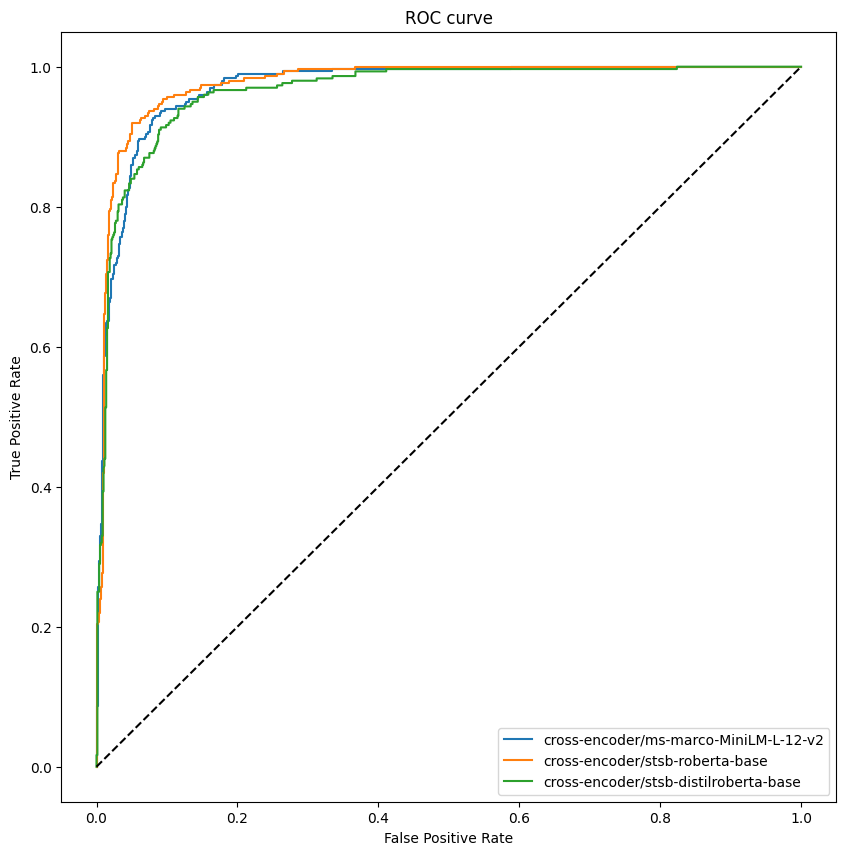

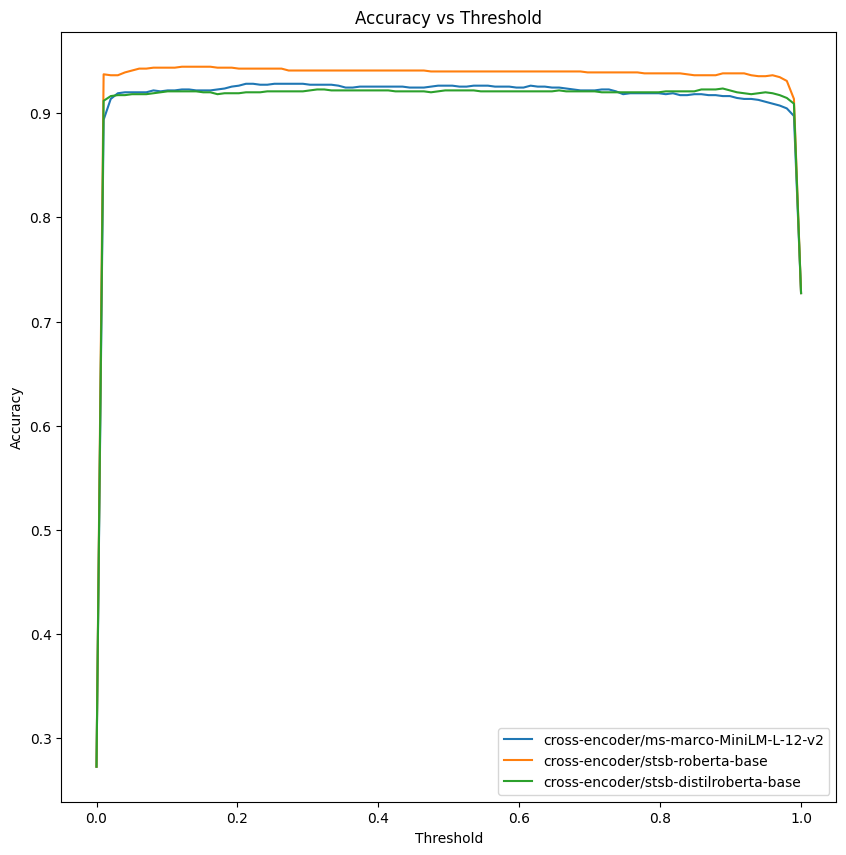

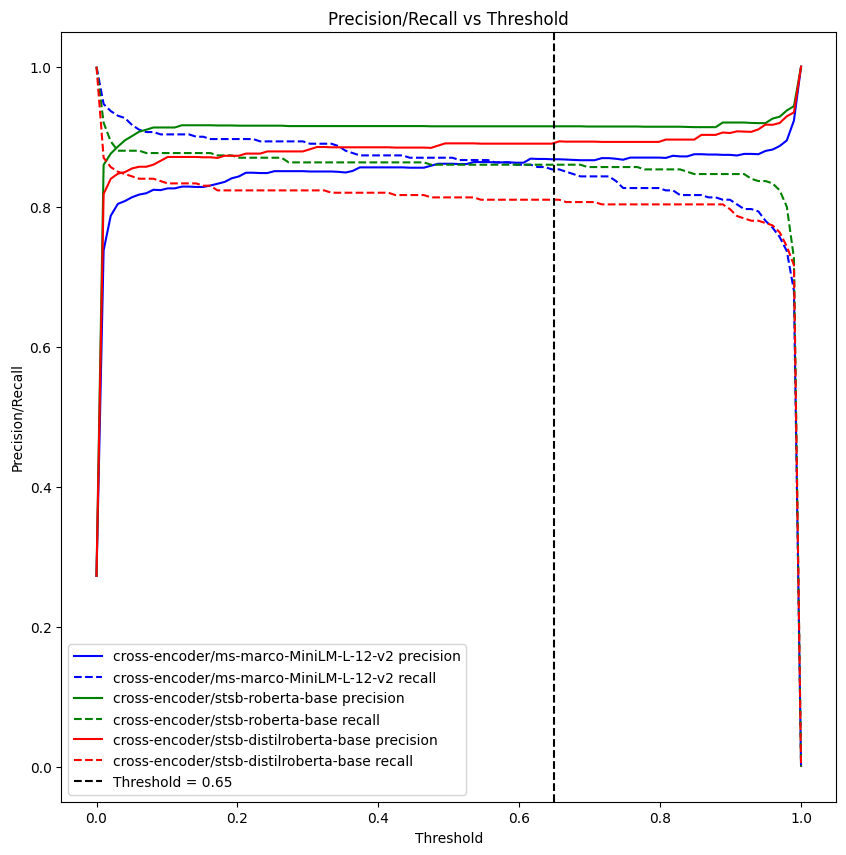

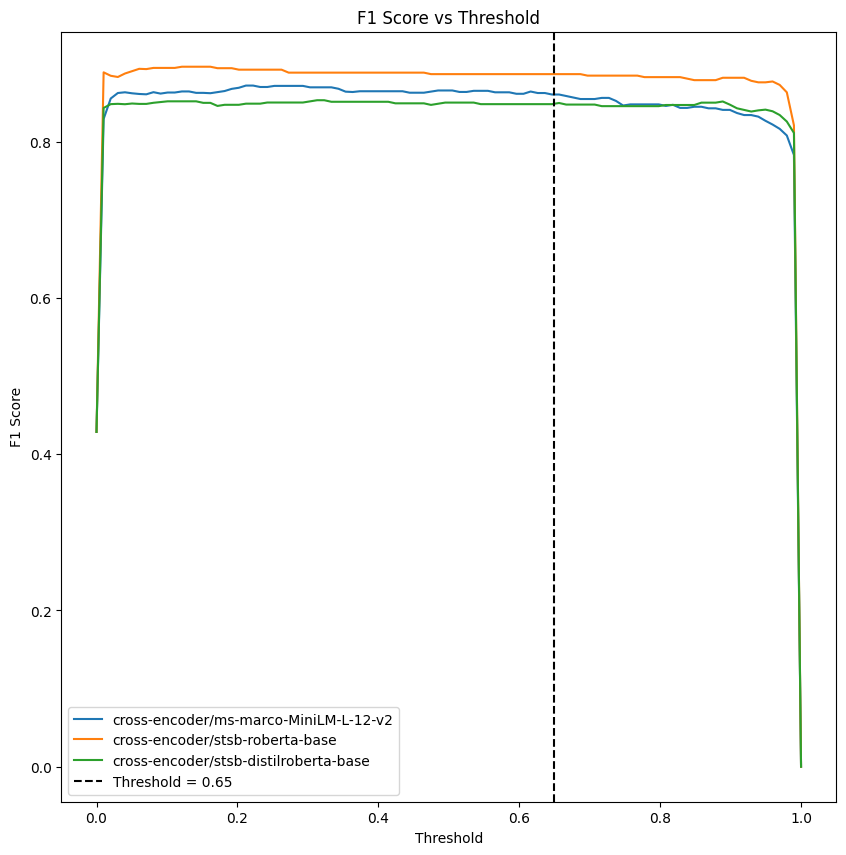

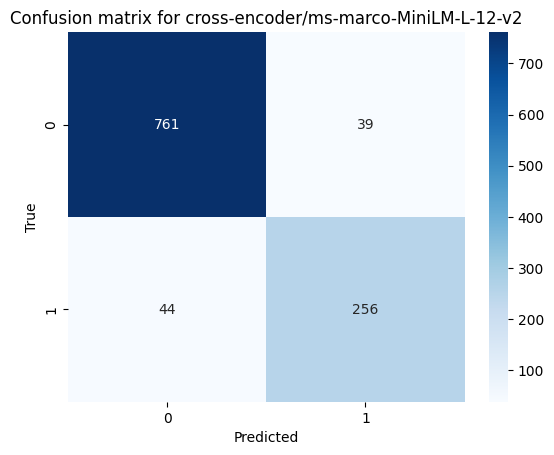

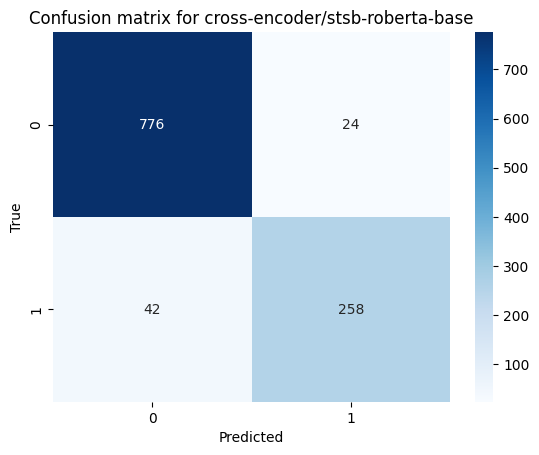

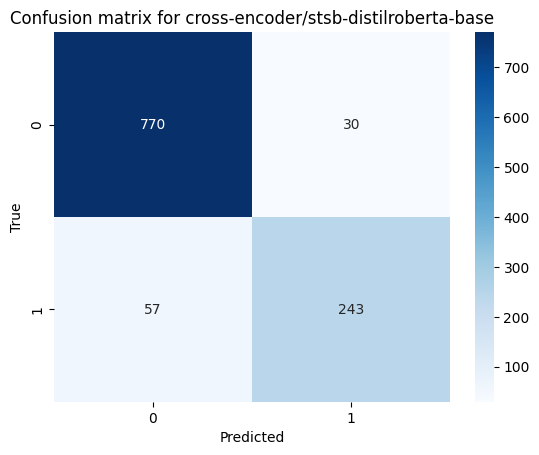

In [33]:
show_results()